# Poor Confidence Analysis
This analysis aims to improve the NER model by studying the predictions done by the model. This is done firstly by identifying the weakness or limitations discovered from the prediction results. So, by looking at the outputs, the confidence score can be the area of focus for this analysis.

The idea of this analysis is to find out if the low confidence scores are justifiable. For example, is the confidence score related to the volume of the dataset, frequency of the labels, or word rarity?

This can be determined by answering these questions:
1. Is there a correlation between label frequency and confidence scores?
2. Are low-confidence predictions associated with rare vocabulary?
3. Do certain entity types show systematic confidence patterns?
4. Is confidence score correlated with word length or complexity?
5. Does context window size affect confidence?

Based on these questions, 

* If low scores correlate with rare labels: Augment training data for underrepresented classes
* If low scores correlate with rare words: Add domain-specific vocabulary for training 
* If low scores are consistent with certain label group: Review annotation
* If low scores are consistent with longer words/phrase: Review span detection
* If low scores cluster in specific positions: Review context window

If all are unclear: Review model architecture or hyperparameter tuning

------
## Data Preparation

### Import Libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats             # correlation

### Load Dataset

In [137]:
# load csv
df = pd.read_csv('results_main.csv')
df.head()

,start,end,text,label,score
0,0,13,ahli parlimen,PERSON,0.646612
1,14,18,umno,ORG,0.919545
2,44,59,utusan malaysia,ORG,0.676499
3,101,114,korea selatan,LOC,0.768719
4,115,126,kementerian,ORG,0.922510


In [179]:
df.info

<bound method DataFrame.info of        start     end                 text    label     score
0          0      13        ahli parlimen   PERSON  0.646612
1         14      18                 umno      ORG  0.919545
2         44      59      utusan malaysia      ORG  0.676499
3        101     114        korea selatan      LOC  0.768719
4        115     126          kementerian      ORG  0.922510
...      ...     ...                  ...      ...       ...
7225  370638  370644               negara      LOC  0.810654
7226  370646  370657          johor bahru      LOC  0.759652
7227  370744  370753            singapura      LOC  0.734750
7228  370789  370808  minyak petrol ron95  PRODUCT  0.777760
7229  370846  370851                johor      LOC  0.838383

[7230 rows x 5 columns]>

--------
## Data Analysis

### Q1: Is there a correlation between label frequency and confidence scores?
Compare confidence scores of high-frequency labels and low-frequency labels.
1. get label distribution
2. set high-frequency labels
3. set low-frequency labels
4. visualize on confidence score 
5. make a rough comparison
6. perform correlation analysis

#### Get Label Distribution

In [138]:
# drop start, end, and score columns
q1 = df.drop(['start', 'end', 'score'], axis = 1)
q1.head()

,text,label
0,ahli parlimen,PERSON
1,umno,ORG
2,utusan malaysia,ORG
3,korea selatan,LOC
4,kementerian,ORG


In [139]:
# normalize text
q1['text'] = q1['text'].str.lower()
q1.head()

,text,label
0,ahli parlimen,PERSON
1,umno,ORG
2,utusan malaysia,ORG
3,korea selatan,LOC
4,kementerian,ORG


In [140]:
# duplicates
q1.drop_duplicates().head()

,text,label
0,ahli parlimen,PERSON
1,umno,ORG
2,utusan malaysia,ORG
3,korea selatan,LOC
4,kementerian,ORG


In [153]:
# label distribution
q1['label'].value_counts()

label
ORG            1720
PERSON         1671
LOC            1539
EVENT           478
TIME            385
GPE             354
PRODUCT         313
MONEY           230
QUANTITY        173
LAW             145
WORK_OF_ART      83
PERCENT          66
CARDINAL         40
NORP             19
FAC              12
ORDINAL           2
Name: count, dtype: int64

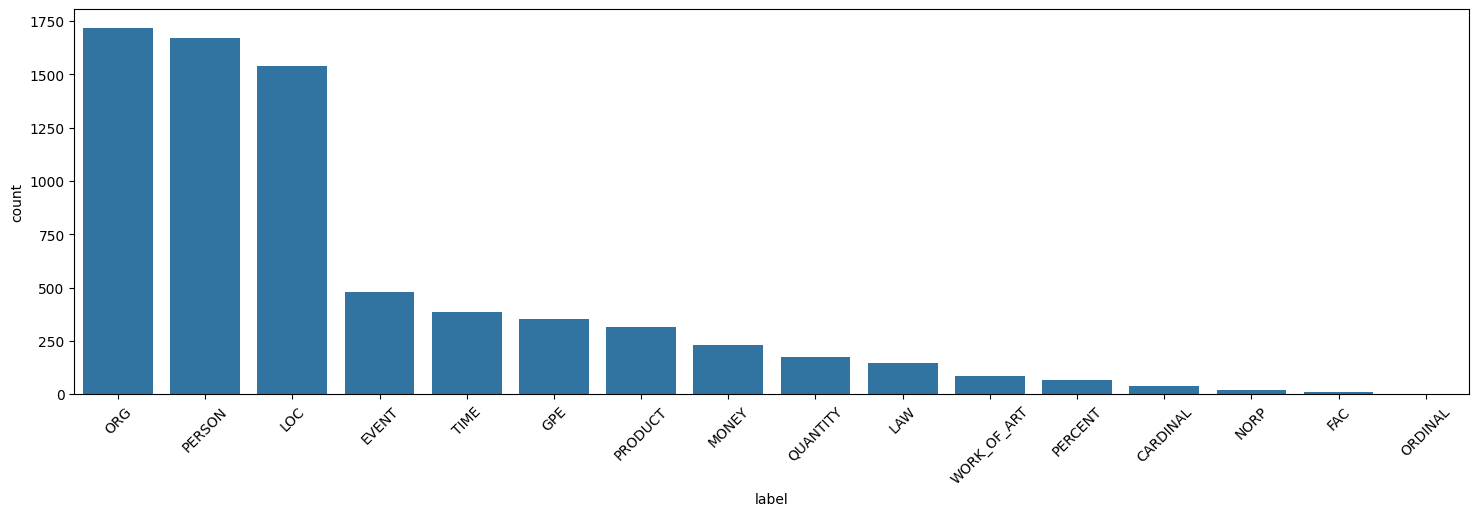

In [142]:
# visualize
label_freq = q1['label'].value_counts().index

plt.figure(figsize=(18,5))
sns.countplot(x=q1['label'],data=q1, order=label_freq)
plt.xticks(rotation=45)
plt.show()

From this graph, it is safe assume that the high-frequency labels are the 3 highest, while the others are teh low-frequency labels.

#### Get High and Low Frequency Labels

In [143]:
# overview
df.head()

,start,end,text,label,score
0,0,13,ahli parlimen,PERSON,0.646612
1,14,18,umno,ORG,0.919545
2,44,59,utusan malaysia,ORG,0.676499
3,101,114,korea selatan,LOC,0.768719
4,115,126,kementerian,ORG,0.922510


In [144]:
# drop columns
q1 = df.drop(['start','end','text'], axis=1)
q1.head()

,label,score
0,PERSON,0.646612
1,ORG,0.919545
2,ORG,0.676499
3,LOC,0.768719
4,ORG,0.922510


In [145]:
# list labels
q1['label'].unique()

array(['PERSON', 'ORG', 'LOC', 'PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL'], dtype=object)

In [146]:
# split into higher and lower frequency groups
high_label = ['PERSON','ORG','LOC']
low_label = ['PRODUCT', 'QUANTITY', 'EVENT', 'GPE',
       'CARDINAL', 'TIME', 'LAW', 'MONEY', 'PERCENT', 'WORK_OF_ART',
       'NORP', 'FAC', 'ORDINAL']

q1_high = q1[q1['label'].isin(high_label)]
q1_low = q1[q1['label'].isin(low_label)]

#### Visualize on Confidence Score

In [ ]:
# get mean score
label_score_mean_high = q1_high.groupby('label')['score'].mean().reset_index()
label_score_mean_low = q1_low.groupby('label')['score'].mean().reset_index()

In [148]:
# sort mean score
label_score_mean_high = label_score_mean_high.sort_values('score', ascending=False)
label_score_mean_low = label_score_mean_low.sort_values('score', ascending=False)

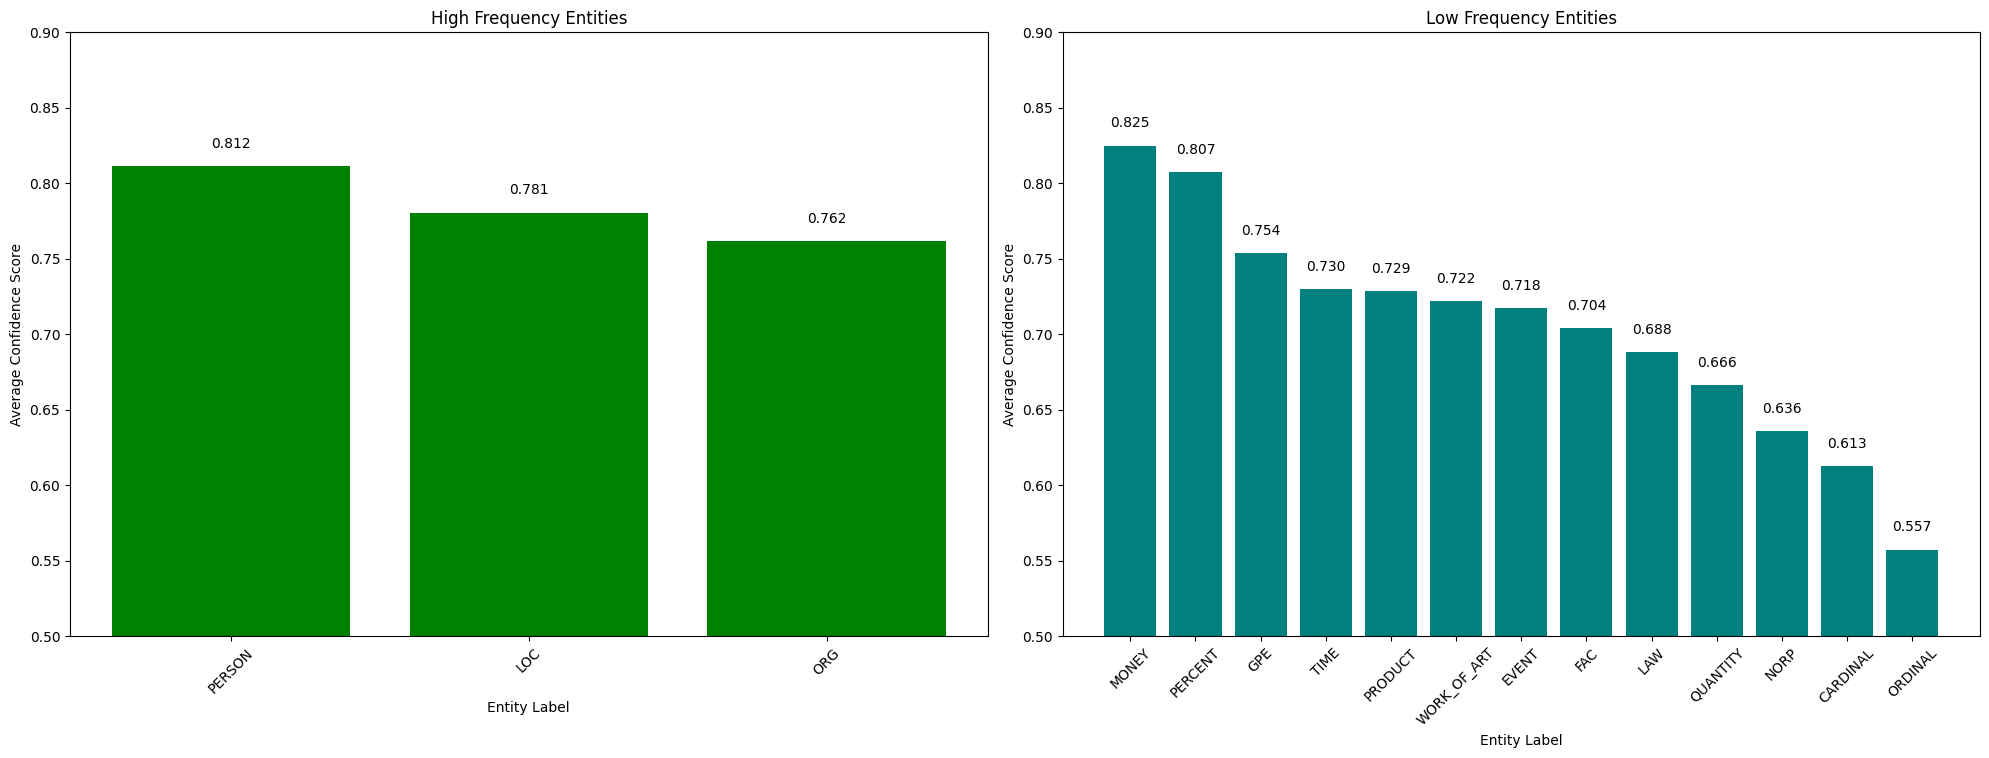

In [149]:
# visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# high frequency labels
bars1 = ax1.bar(label_score_mean_high['label'], 
               label_score_mean_high['score'],
               color='green')

# labeling
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax1.set_title('High Frequency Entities')
ax1.set_xlabel('Entity Label')
ax1.set_ylabel('Average Confidence Score')
ax1.set_ylim(0.5, 0.9)
ax1.tick_params(axis='x', rotation=45)

# low frequency labels
bars2 = ax2.bar(label_score_mean_low['label'], 
               label_score_mean_low['score'],
               color='teal')

# labeling
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{height:.3f}', ha='center', va='bottom', fontsize=10)

# setting
ax2.set_title('Low Frequency Entities')
ax2.set_xlabel('Entity Label')
ax2.set_ylabel('Average Confidence Score')
ax2.set_ylim(0.5, 0.9)
ax2.tick_params(axis='x', rotation=45)

# display
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Make room for suptitle
plt.show()

Based on these graphs, the lowest confidence score for the high-frequency labels is around 76%, while the highest confidence score for the low-frequency labels is around 82%. This means that even if the label is relatively rare, the confidence score can still be high. Even so, it cannot be a certain that there is no correlation between the label rarity and the confidence score. Therefore, a correlation analysis can be done to further confirm this.

#### Perform Correlation Analysis

In [164]:
# get label frequency
label_freq = q1['label'].value_counts().reset_index()
label_freq.columns = ['label', 'frequency']

# get mean confidence score
label_confidence = q1.groupby('label')['score'].mean().reset_index()
label_confidence.columns = ['label', 'avg_confidence']

# merge these two
label_analysis = pd.merge(label_freq, label_confidence, on='label')

In [ ]:
# pearson correlation
pearson_corr, p_value = stats.pearsonr(
    label_analysis['frequency'],
    label_analysis['avg_confidence']
)

print(f"Pearson Correlation Coefficient: {pearson_corr:.3f}")
print(f"P-value: {p_value:.4f}")

# interpretation
abs_corr = abs(pearson_corr)
if abs_corr >= 0.9:
    strength = "Very strong correlation"
elif abs_corr >= 0.7:
    strength = "Strong correlation"
elif abs_corr >= 0.5:
    strength = "Moderate correlation"
elif abs_corr >= 0.3:
    strength = "Weak correlation"
else:
    strength = "Very weak correlation"

direction = "positive" if pearson_corr > 0 else "negative"

# inference
significance = "statistically significant" if p_value < 0.05 else "not statistically significant"

print(f"\n{strength} ({direction}) relationship between label frequency and confidence scores")
print(f"This relationship is {significance} (p = {p_value:.4f})")

if p_value < 0.05:
    if pearson_corr > 0.3:
        print("Consider augmenting training data for low-frequency labels")
    elif pearson_corr < -0.3:
        print("Investigate potential data quality issues with common labels")
    else:
        print("Action: Focus on other factors like context or word complexity")
else:
    print("Confidence scores likely depend on other factors beyond label frequency")

Pearson Correlation Coefficient: 0.520
P-value: 0.0389

Moderate correlation (positive) relationship between label frequency and confidence scores
This relationship is statistically significant (p = 0.0389)
Consider augmenting training data for low-frequency labels


### Q2: Are low-confidence predictions associated with rare vocabulary?
Compare word frequency between low-scoring entities and high-scoring ones.
1. get word frequency
2. get confidence score
3. visualize and compare

### Q3: Do certain entity types show systematic confidence patterns?
Analyze score distributions per label type (e.g., TIME vs. LOC) using box plots or violin plots.

### Q4: Is confidence score correlated with word length or complexity?
Compute correlation between entity string length/number of tokens and confidence scores.

### Q5: Does context window size affect confidence?
Examine scores relative to entity position in sentence (beginning, middle, end).